In [3]:
from binance_historical_data import BinanceDataDumper
import pandas as pd
import pathlib
from tqdm import tqdm


In [4]:
data_dumper = BinanceDataDumper(
    path_dir_where_to_dump = '../data/',
    asset_class = 'spot',
    data_type = 'klines',
    data_frequency = '5m'
)
x = data_dumper.dump_data(
    tickers = ['BTCUSDT'],
    date_start = None,
    date_end = None,
    is_to_update_existing = True,
    # tickers_to_exclude = ["UST"]
)

---> Found overall tickers: 2360
---> Filter to asked tickers: 1
------> Tickers left: 1
Download full data for 1 tickers: 
---> Data will be saved here: /Users/johnz/Library/CloudStorage/GoogleDrive-john23@berkeley.edu/My Drive/CryptoFutures/data/spot
---> Data Frequency: 5m
---> Start Date: 20170101
---> End Date: 20231124


Tickers:   0%|          | 0/1 [00:00<?, ?it/s]

monthly files to download:   0%|          | 0/75 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/23 [00:00<?, ?files/s]

Tried to dump data for 1 tickers:
---> For BTCUSDT new data saved for: 75 months 22 days


In [9]:
def process_klines_data(columns, token_lists):
    """
    futures
    :param columns: for data columns
    :param token_lists: tokens to get data for
    :return:
    """
    path = pathlib.Path.cwd().parent / 'data' / "futures" / 'um' / 'monthly' / 'klines'
    for token in token_lists:
        try:
            files = path / token / '5m'
            csv_files = files.glob('*.csv')
            dfs = []
            for file in csv_files:
                df = pd.read_csv(file, index_col=None, names=columns)
                idx = df.index[df['open_time'] != 'open_time']
                df = df.loc[idx].reset_index(drop=True)
                for col in columns:
                    df[col] = df[col].astype(float)
                dfs.append(df)
            df_all = pd.concat(dfs, axis=0, ignore_index=True)
        except Exception as e:
            print(f'Error for {token}: {e}')
    return df_all

In [28]:
def process_klines_data_spot(columns, token):
    """
    futures
    :param columns: for data columns
    :param token_lists: tokens to get data for
    :return:
    """
    monthly_path = pathlib.Path.cwd().parent / 'data' / "spot" / 'monthly' / 'klines'
    daily_path = pathlib.Path.cwd().parent / 'data' / "spot" / 'daily' / 'klines'
    all_paths = [monthly_path, daily_path]
    # for token in token_lists:
    df_final = []
    for path in all_paths:
        try:
            files = path / token / '5m'
            csv_files = files.glob('*.csv')
            dfs = []
            for file in csv_files:
                df = pd.read_csv(file, index_col=None, names=columns)
                idx = df.index[df['open_time'] == 'open_time']
                if idx.shape[0] > 0:
                    print(f'Number of incorrect rows: {idx.shape} for {file}')
                # df = df.loc[idx].reset_index(drop=True)
                for col in columns:
                    df[col] = df[col].astype(float)
                dfs.append(df)
            df_all = pd.concat(dfs, axis=0, ignore_index=True)
            df_final.append(df_all)
        except Exception as e:
            print(f'Error for {token}: {e}')
    df_final = pd.concat(df_final, axis = 0)
    df_final = df_final.drop_duplicates(subset = ['open_time'])
    return df_final

In [22]:
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume',
           'close_time', 'quote_asset_volume', 'number_of_trades',
           'taker_buy_base_volume', 'taker_buy_quote_asset_volume', 'ignore']

df_all = process_klines_data_spot(columns, ['BTCUSDT'])

In [30]:
from ta import add_all_ta_features
def load_klines_data(universe, columns, save = True):
    dfs = {}
    sample = {}
    for token in tqdm(universe):
        df = process_klines_data_spot(columns, token)
        df['open_time'] = pd.to_datetime(df['open_time'], unit = 'ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit = 'ms')
        df['token'] = token
        df = df.sort_values(by = 'open_time', ignore_index = True)
        df = add_all_ta_features(df, open = 'open', high = 'high', low = 'low',
                                 close = 'close', volume = 'volume', fillna = True)
        if save:
            df.to_feather(f'../data/processed_data/{token}_5m_spot.feather')
        dfs[token] = df
    return dfs

In [31]:
universe = ['BTCUSDT']
columns_futures = ['open_time', 'open', 'high', 'low', 'close', 'volume',
           'close_time', 'quote_asset_volume', 'number_of_trades',
           'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
           'ignore']

columns_spot = ['open_time', 'open', 'high', 'low', 'close', 'volume',
           'close_time', 'quote_asset_volume', 'number_of_trades',
           'taker_buy_base_volume', 'taker_buy_quote_asset_volume', 'ignore']

path = pathlib.Path.cwd().parent / 'data' / 'processed_futures'
dfs = load_klines_data(universe, columns_spot)

100%|██████████| 1/1 [02:45<00:00, 165.16s/it]


In [35]:
df_spot = dfs['BTCUSDT'].copy()

In [37]:
df_fut = pd.read_feather('../data/processed_data/BTCUSDT_5m.feather')

In [39]:
df_fut_filt = df_fut[columns_spot[:8]]
df_spot_filt = df_spot[columns_spot[:8]]

In [40]:
df_comb = df_fut_filt.merge(df_spot_filt, left_on = ['open_time'], right_on = ['open_time'])

In [45]:
df_comb['ret_480min_fut'] = df_comb['close_x'].pct_change((-480//5))
df_comb['ret_480min_spot'] = df_comb['close_y'].pct_change((-480//5))

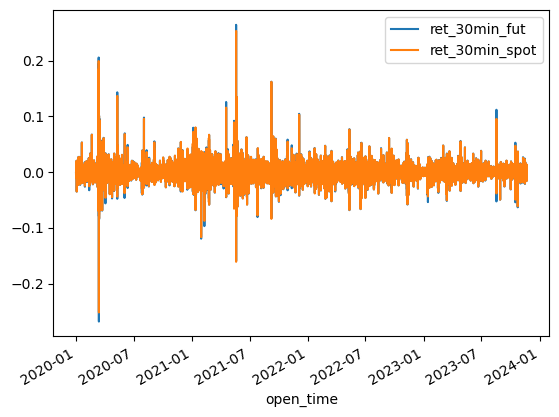

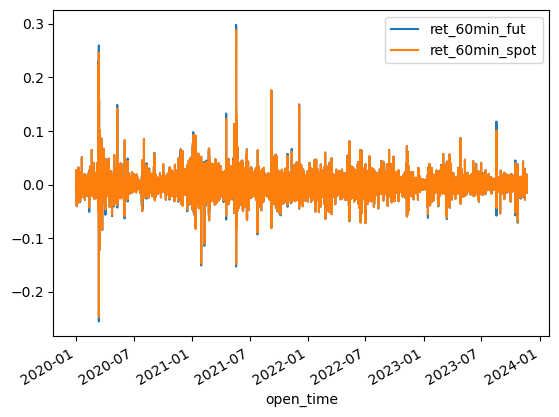

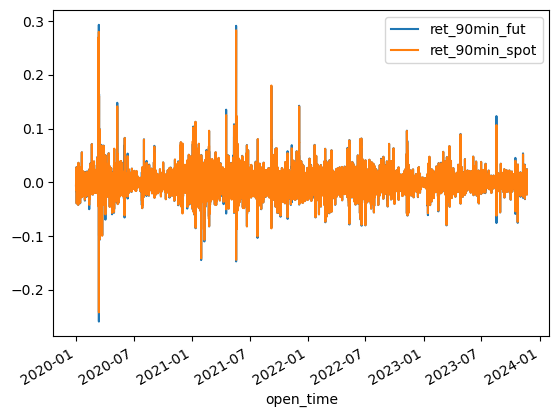

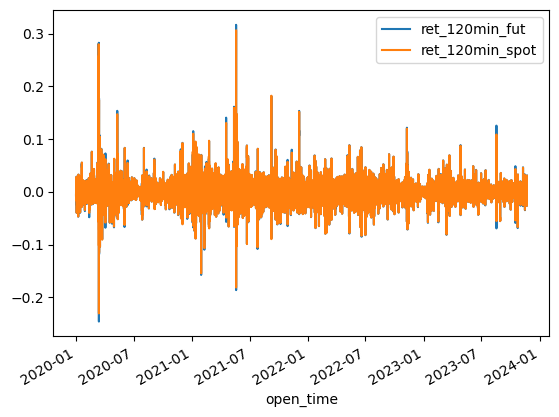

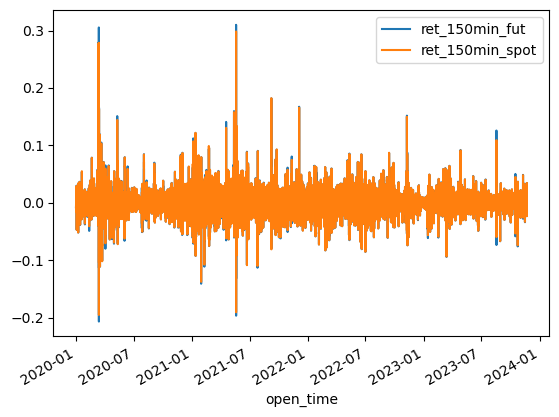

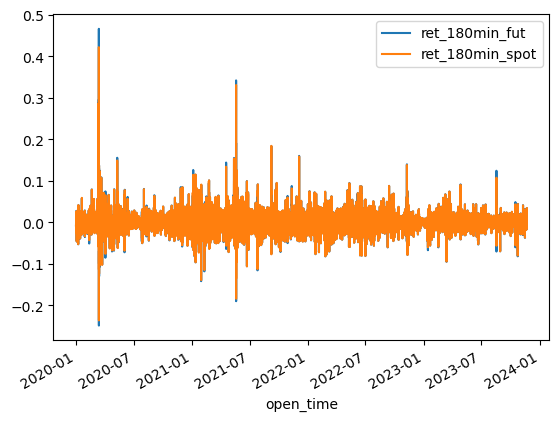

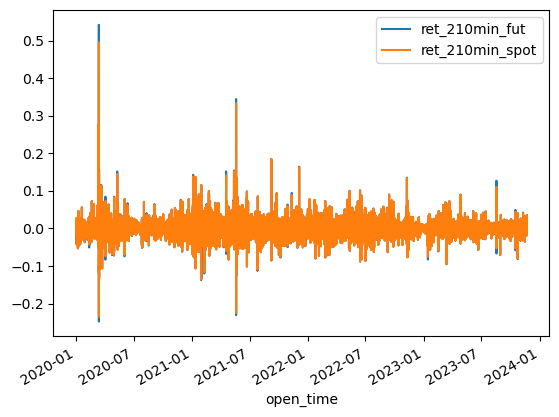

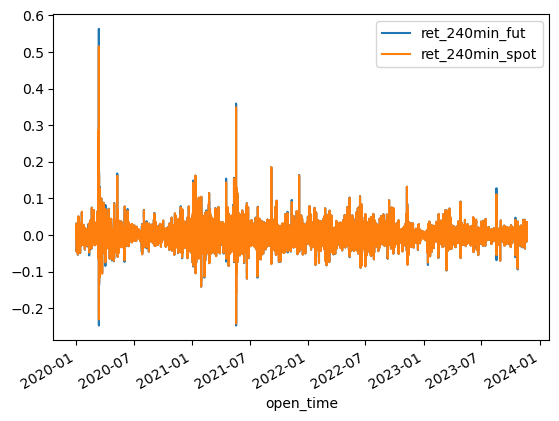

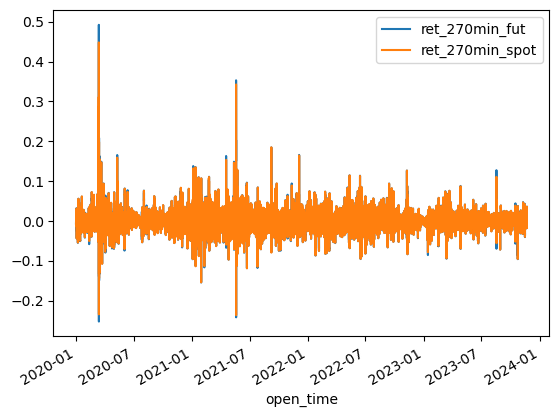

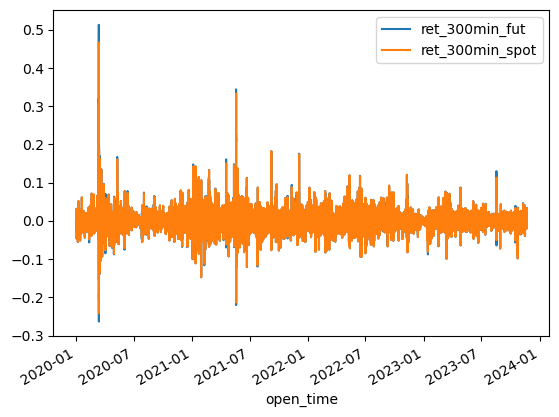

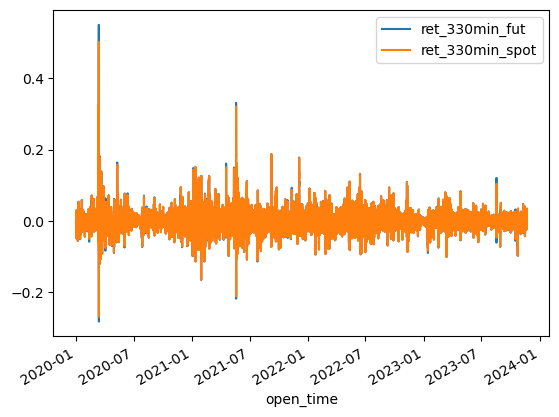

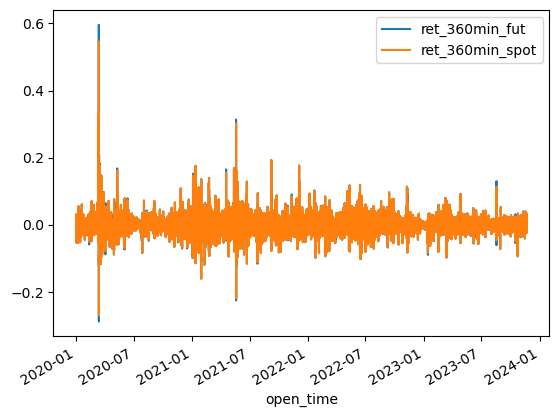

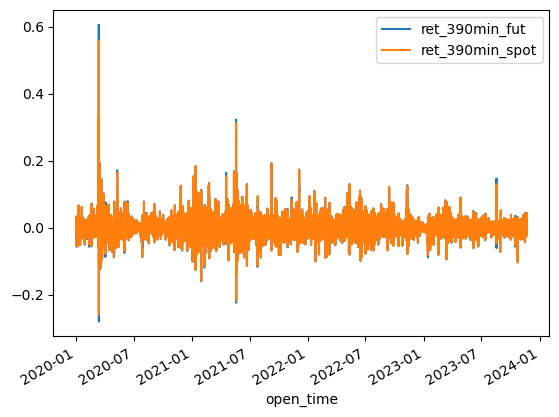

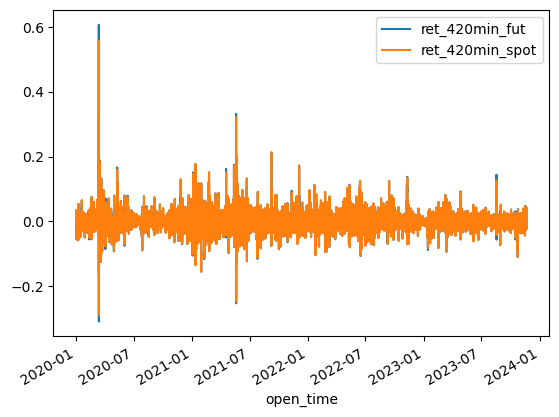

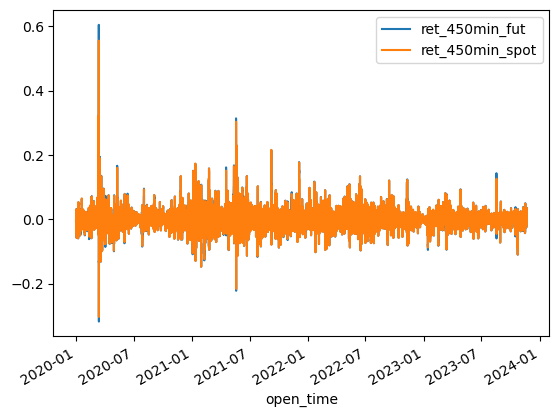

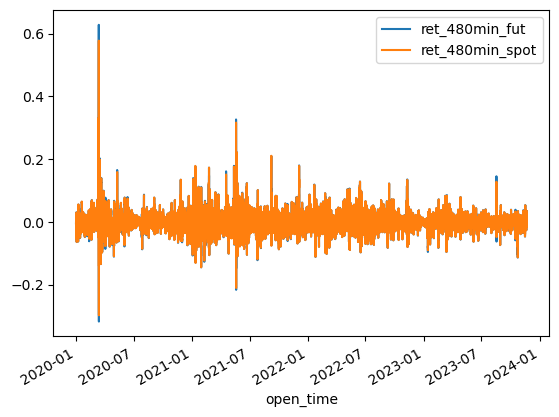

In [48]:
target_intervals = [30, 60, 90, 120, 150, 180, 210, 240,
                    270, 300, 330, 360, 390, 420, 450, 480]
interval = 5
for target_interval in target_intervals:
    delta = target_interval // 5
    y_fut, y_spot = f'ret_{target_interval}min_fut', f'ret_{target_interval}min_spot'
    df_comb[f'ret_{target_interval}min_fut'] = df_comb['close_x'].pct_change((-delta))
    df_comb[f'ret_{target_interval}min_spot'] = df_comb['close_y'].pct_change((-delta))
    ax = df_comb.plot(x = 'open_time', y = [y_fut, y_spot])

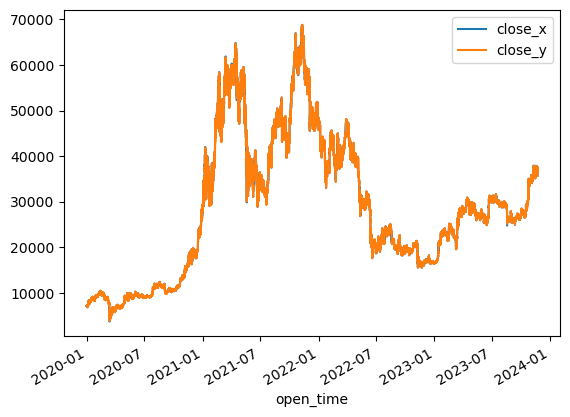

In [43]:
ax = df_comb.plot(x = 'open_time', y = ['close_x', 'close_y'])

In [3]:
from binance.spot import Spot
import time
from datetime import datetime, timedelta

exchange_key = 'HHwPdDKvCO3zxbLqQbjxcb0N2wDNDs2aD5aIz3M3GsuiIntsgfV0wWWIaqfnKriw'
end_time = round(time.time() * 1000)
end_datetime = datetime.fromtimestamp(end_time / 1000.0)


client = Spot(api_key = exchange_key)

In [5]:
btc_data = client.klines(symbol = 'BTCUSDT', interval = '5m', limit = 1000)

In [9]:
import pandas as pd
exchange_key = 'HHwPdDKvCO3zxbLqQbjxcb0N2wDNDs2aD5aIz3M3GsuiIntsgfV0wWWIaqfnKriw'
end_time = round(time.time() * 1000)
end_datetime = datetime.fromtimestamp(end_time / 1000.0)

client = Spot(api_key = exchange_key)

kline = client.klines("BTCUSDT", '5m', endTime = end_time, limit = 1000)

columns_spot = ['open_time', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_volume', 'taker_buy_quote_asset_volume', 'ignore']

df = pd.DataFrame(kline, columns = columns_spot)
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

NameError: name 'pd' is not defined

In [11]:
df_prev = pd.read_feather('../data/df_btc_with_features_5m_spot.feather')

In [12]:
cols = pd.DataFrame(df_prev.columns)

In [13]:
cols

,0
0,open_time
1,open
2,high
3,low
4,close
...,...
174,target_420m
175,close_90lag
176,target_450m
177,close_96lag
